In [1]:
import json
import psycopg2
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline

In [2]:
# Connect to the local postgres database, using the train2 latest data
try:
    #conn = psycopg2.connect("dbname='traindata' user='traindata' host='localhost' password='somepassword'")
    conn = psycopg2.connect("dbname='train2' user='train2' host='localhost' password='somepassword'")
except:
    print("Database connection failed")

In [4]:
#cur = conn.cursor()
#cur.execute("""SELECT * FROM data_route LIMIT 10""")
#cur.execute("""SELECT * FROM data_trip WHERE route_id=1 LIMIT 10""")
#cur.execute("""SELECT id,stop_id,gtfs_stop_id,trip_id FROM data_sample WHERE trip_id=88330 LIMIT 100""")
#print("Got {} rows".format(cur.rowcount))
#print(cur.fetchall())

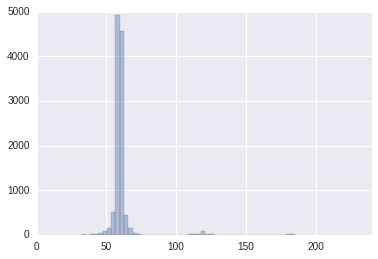

In [7]:
res = pd.read_sql_query("""
    SELECT gtfs_stop_id, actual_departure
    FROM data_sample
    WHERE trip_id IN (SELECT id FROM data_trip WHERE route_id=1)
    """, conn)
agg_deltas = pd.Series()
for id in set(res["gtfs_stop_id"]):
    subset = res[(res["gtfs_stop_id"] == id)].dropna()
    subset = subset.sort_values("actual_departure")
    #subset = subset["actual_departure"].diff(-1)
    subset_deltas = subset.diff()
    agg_deltas = agg_deltas.append(subset_deltas["actual_departure"])
deltas = agg_deltas.dropna().values/1000000000/60
deltas = map(int, deltas)
to_remove = [i for i, val in enumerate(deltas) if val > 60*4]
for index in reversed(to_remove):
    del deltas[index]
ax = sns.distplot(deltas, kde=False)
_ = ax.set_xlim(0, 60*4)

In [6]:
all_stops = json.loads(requests.get('http://otrain.org/api/v1/stops').text)
stop_lut = {}
for stop_info in all_stops:
    stop_lut.update({stop_info['stop_id'] : [stop_info['heb_stop_names'][0], stop_info['stop_name']]})